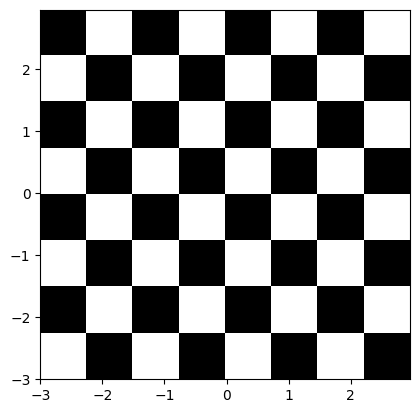

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def func3(x, y):
    return (1 - x / 2 + x**5 + y**3) * np.exp(-(x**2 + y**2))
# make these smaller to increase the resolution
dx, dy = 0.05, 0.05
x = np.arange(-3.0, 3.0, dx)
y = np.arange(-3.0, 3.0, dy)
X, Y = np.meshgrid(x, y)
extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig = plt.figure(frameon=False)
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)
Z2 = func3(X, Y)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle
import random
import pathlib
import datetime

from IPython import display
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter

In [3]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

In [4]:
tf.random.set_seed(seed=20)

In [5]:
def add_noise_blur(image, rows=128, cols=128):
    #add random noise
    scale = tf.random.uniform([1], minval = 0.01, maxval = 0.1, dtype = tf.float32 )
    noise = tf.random.normal([rows, cols, 1], mean = 0.0, stddev = 1.0)
    #blur with a random sigma
    # sigmaIn = np.random.uniform(low = 1.0, high = 2.0 )
    sigmaIn = tf.random.uniform(shape=[], minval = 1.0, maxval = 2.0 )
    #image = gaussian_filter(image, sigma = sigmaIn)
    noise = gaussian_filter(noise, sigma = sigmaIn.numpy())
    image *= (1.0 + scale*noise)
    #print("scale %f sigma %f" % (scale, sigmaIn))
    return image

In [6]:
def normalize(dataY):
    max = tf.reduce_max(dataY)
    min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    dataY = (dataY - min)/(max - min)
    return dataY

In [7]:
def normalizeTarget(image, bFlag = False):
    image = (image - 1.0) / (9.0)
    if bFlag:
        image = 2.0*image - 1.0
    return image

In [8]:
### EoNormalization

In [9]:
def load(image_file):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, (128,128))
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [10]:
def normalize_val(image, target):
    input_image = add_noise_blur(image)
    return input_image , target

In [11]:
def load_image_train(image_file, target_file):
    input_image = load(image_file)
    target_image = load(target_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [12]:
def load_image_val(image_file, target_file):    
    input_image = load(image_file)
    target_image = load(target_file)
    # input_image = add_noise_blur(image_file)
    input_image = normalize(input_image)

    return input_image , target_image 

### Generator Model

In [13]:
OUTPUT_CHANNELS = 1

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [15]:
# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(inp, 0))
# print (down_result.shape)

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [17]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
        downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 3),  # (batch_size, 64, 64, 128)
        downsample(256, 3),  # (batch_size, 32, 32, 256)
        downsample(512, 3),  # (batch_size, 16, 16, 512)
        downsample(512, 3),  # (batch_size, 8, 8, 512)
        downsample(512, 3),  # (batch_size, 4, 4, 512)
        downsample(512, 3),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
        upsample(512, 3),  # (batch_size, 16, 16, 1024)
        upsample(256, 3),  # (batch_size, 32, 32, 512)
        upsample(128, 3),  # (batch_size, 64, 64, 256)
        upsample(64, 3),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
# Visualizing generator architecture
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [20]:
# Testing the generator
# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

In [21]:
# gen_output.shape

In [22]:
# Generator loss
LAMBDA = 100
loss_object = tf.keras.losses.MeanSquaredError()
loss_tracker = tf.keras.metrics.Mean(name="loss")
val_loss_tracker = tf.keras.metrics.Mean(name="loss")

In [23]:
def generator_loss(gen_output, target):
    #Possible addition: regularizer
    gan_loss = loss_object(gen_output, target)
    return gan_loss

In [24]:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

In [25]:
MODEL_PATH = "resultsspie/model_weights/mse_model"
BEST_PATH = "resultsspie-1/model_weights/best_mse_model"

In [95]:
generator.load_weights(BEST_PATH)

In [27]:
def generate_images2(model, test_input, epoch, step):
    prediction = model(test_input, training=False)
    display_list = [test_input[0], prediction[0]]
    title = ['Input', 'Predicted']
    for i in range(2):
        plt.ioff()
        plt.subplot(1, 2, i+1)
        plt.title(title[i], fontsize=15)
        if i ==0:
            plt.imshow(display_list[i], cmap='bwr')
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
        plt.colorbar(location='bottom',pad=0.10)
        plt.axis('on')
    plt.axis('on')
    plt.savefig(f'mod-patient-{epoch}-{step}.png',bbox_inches='tight')
    plt.close

In [28]:
def load2(image_file,size=(508,2596)):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, size)
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [29]:
def normalize2(dataY):
    dataY = 1 - dataY
    return dataY

In [288]:
## For baseline

In [30]:
# dataset2_img = glob.glob('D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30/*')

# For new data
dataset2_img = glob.glob('../../../../TrainData/30/*')


In [31]:
dataset2_img

['../../../../TrainData/30\\displacement.txt',
 '../../../../TrainData/30\\logFile.txt',
 '../../../../TrainData/30\\log_modulus_200x200.raw',
 '../../../../TrainData/30\\modulus_200x200.raw',
 '../../../../TrainData/30\\pred.raw',
 '../../../../TrainData/30\\uX_200x200.raw',
 '../../../../TrainData/30\\uY_200x200.raw']

In [32]:
disp_img = load2(dataset2_img[6],size=(200,200))

In [ ]:
# def generate_images2(model, test_input, epoch, step):
#     prediction = model(test_input, training=False)
#     display_list = [test_input[0], prediction[0]]
#     title = ['Input', 'Predicted']
#     for i in range(2):
#         plt.ioff()
#         plt.subplot(1, 2, i+1)
#         plt.title(title[i], fontsize=15)
#         if i ==0:
#             plt.imshow(display_list[i], cmap='bwr')
#         else:
#             plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
#         plt.colorbar(location='bottom',pad=0.10)
#         plt.axis('on')
#     plt.axis('on')
#     plt.savefig(f'mod-patient-{epoch}-{step}.png',bbox_inches='tight')
#     plt.close

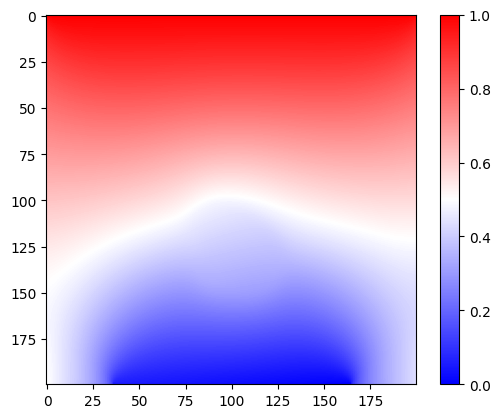

In [42]:
disp_img = normalize(disp_img)
# plt.figure(figsize=(4, 4))
plt.imshow(disp_img, cmap='bwr')
plt.colorbar()

In [181]:
from matplotlib.patches import Rectangle

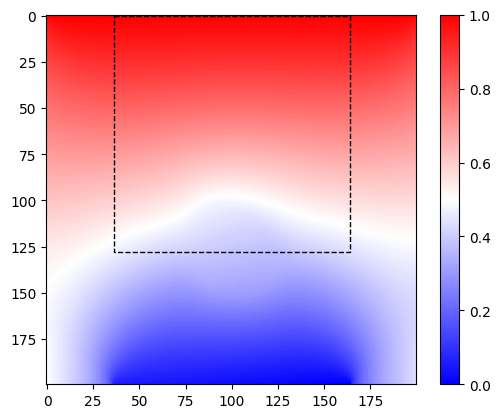

In [191]:
disp_img = normalize(disp_img)
# plt.figure(figsize=(4, 4))
plt.imshow(disp_img, cmap='bwr')
plt.gca().add_patch(Rectangle((36,0),128,128,linestyle='dashed',linewidth=1,edgecolor='black',facecolor='none'))
plt.colorbar()


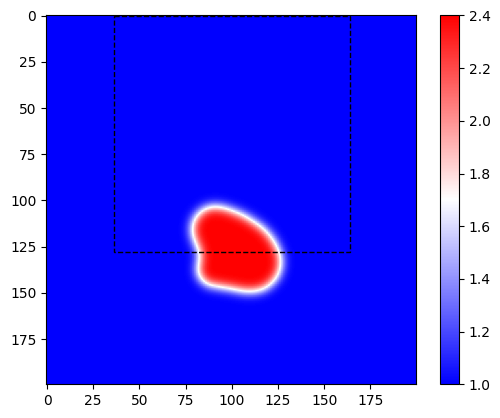

In [192]:
mod_img  = load2(dataset2_img[3],size=(200,200))
# gt = normalize2(gt)
# gt = gt[0+30:128+30,36:164]
plt.imshow(mod_img, cmap='bwr') 
plt.gca().add_patch(Rectangle((36,0),128,128,linestyle='dashed',linewidth=1,edgecolor='black',facecolor='none'))
plt.colorbar()

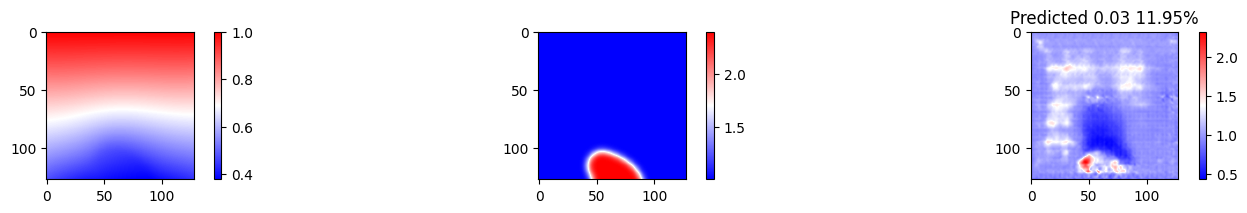

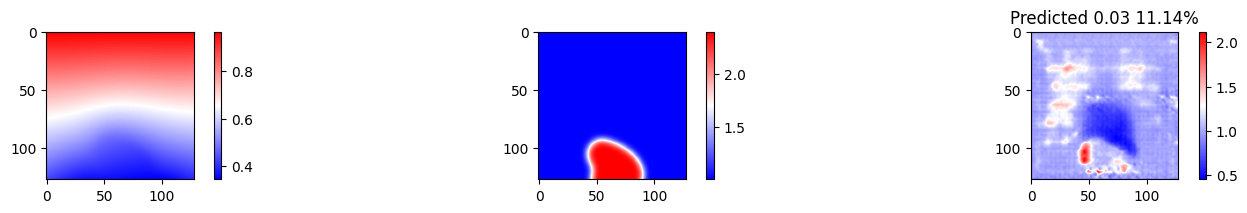

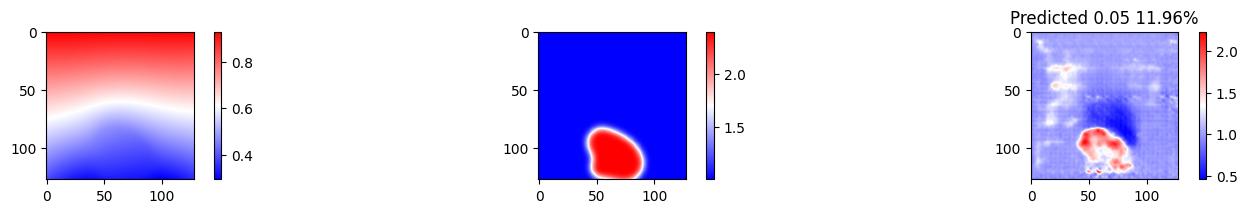

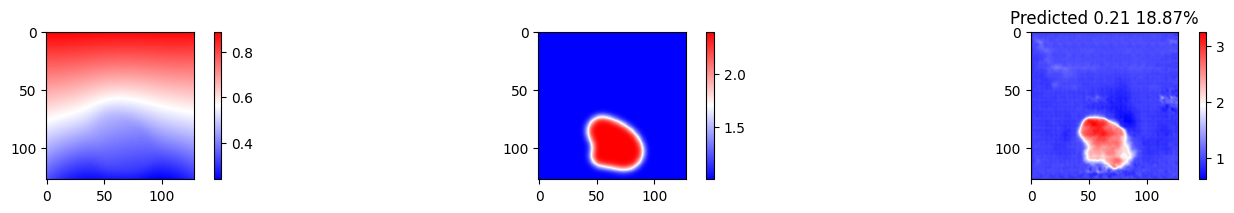

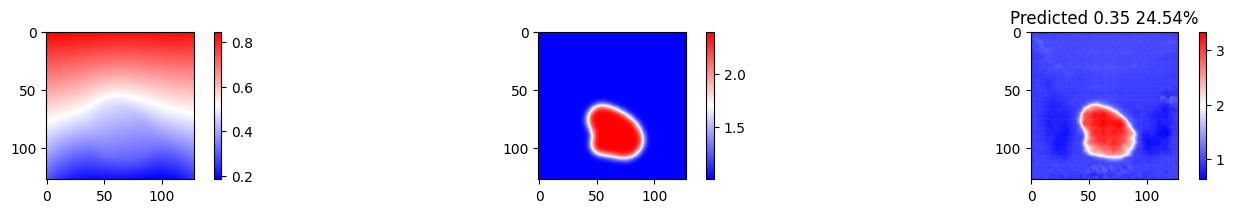

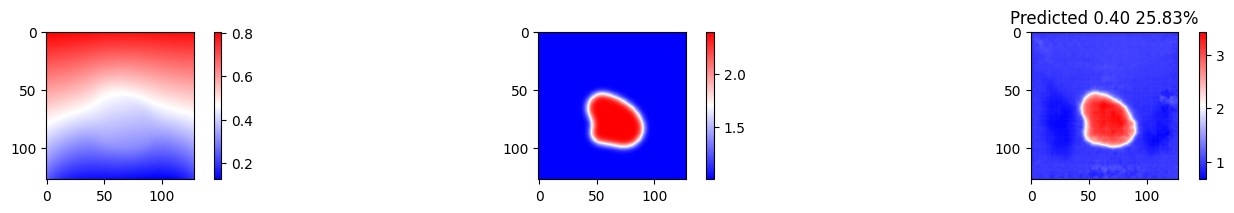

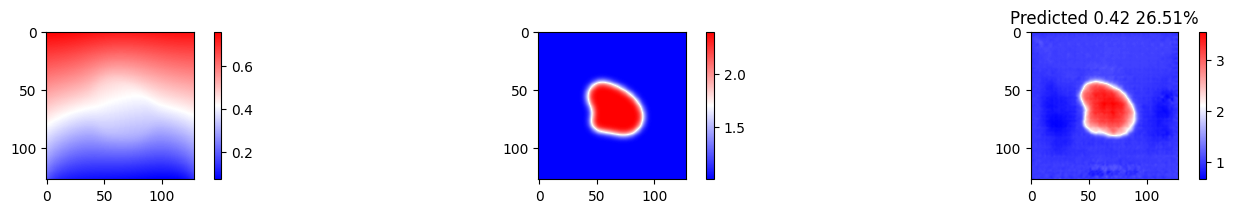

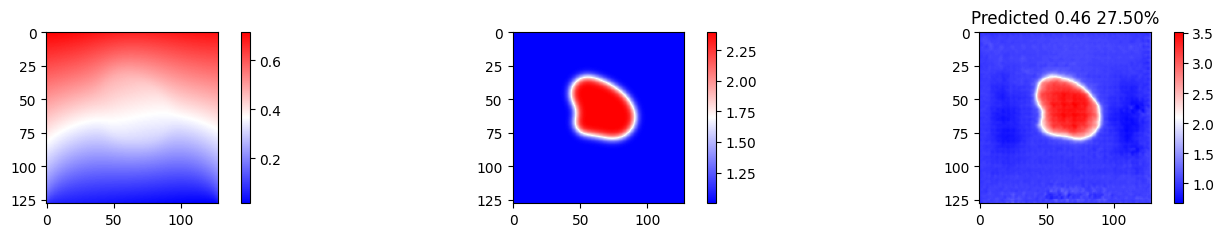

In [110]:
# extracted = exp_img[200-128:200, 36:164]
# Moving the extraction box of 128*128 downward from the center position(position of transducer)
k = 0
for i in range(8):
    pos=i*10
    extracted_disp_img = disp_img[0+pos:128+pos,36:164]
    extracted_mod_img =  mod_img[0+pos:128+pos,36:164]

    plt.figure(figsize=(18, 18))
    plt.subplot(8, 3, k+1)
    plt.imshow(extracted_disp_img, cmap='bwr')
    plt.colorbar()

    plt.subplot(8, 3, k+2)
    plt.imshow(extracted_mod_img, cmap='bwr')
    plt.colorbar()

    predicted_mod_img = generator(extracted_disp_img[tf.newaxis, ...], training=True)

    plt.subplot(8, 3, k+3)
    mse_loss = tf.keras.losses.MeanSquaredError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
    title1 = f'Predicted {mse_loss:.2f} {mape_loss:.2f}%'
    plt.title(title1)
    plt.imshow(predicted_mod_img[0], cmap='bwr')
    plt.colorbar()

    k = k + 3
    # if i == 2:
    #     break
    
# plt.tight_layout(
plt.subplots_adjust(hspace=0.01, wspace=0.01)
plt.savefig('traversal.png', bbox_inches='tight')
plt.show()
plt.close()

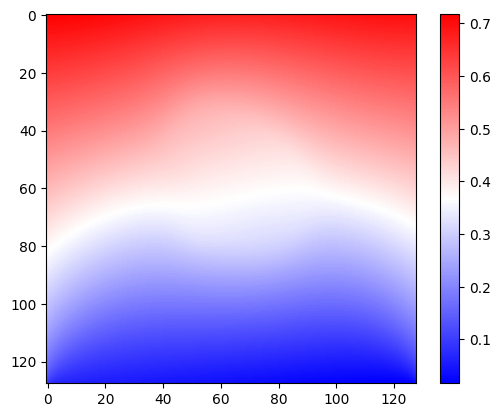

In [111]:
plt.imshow(extracted_disp_img, cmap='bwr')
plt.colorbar()

In [112]:
prediction = generator(extracted_disp_img[tf.newaxis, ...], training=True)

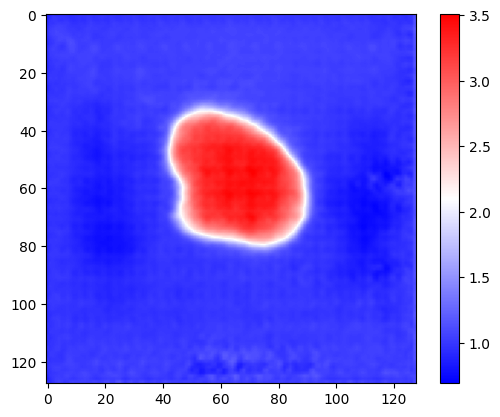

In [113]:
plt.imshow(prediction[0], cmap='bwr') #, norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
plt.colorbar()

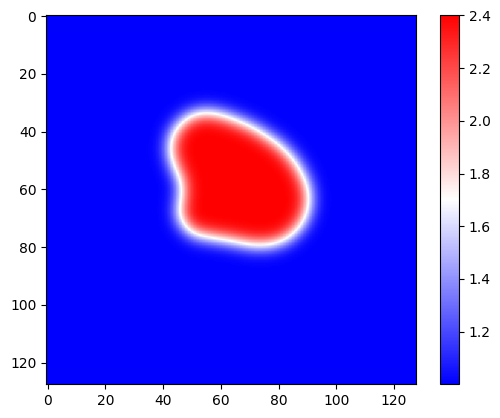

In [115]:
# gt  = load2(dataset2_img[3],size=(200,200))
# # gt = normalize2(gt)
# gt = gt[0+30:128+30,36:164]
plt.imshow(extracted_mod_img, cmap='bwr') 
plt.colorbar()

In [119]:
from skimage import filters

In [121]:
extracted_mod_img.shape

TensorShape([128, 128, 1])

In [127]:
numpy_data = extracted_mod_img[:,:,0].numpy()

In [128]:
val = filters.threshold_otsu(numpy_data)

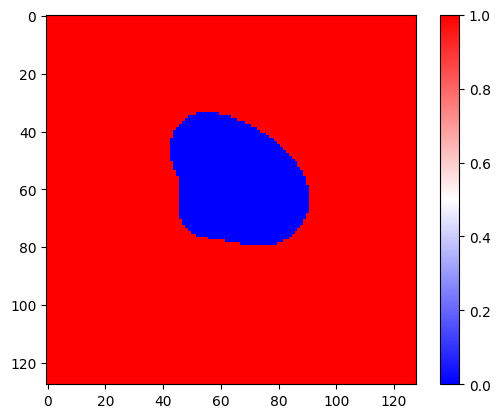

In [131]:
plt.imshow(numpy_data < val, cmap='bwr', interpolation='nearest')
plt.colorbar()

In [142]:
def display_otsus(extracted_mod_img):
    numpy_data = extracted_mod_img[:,:,0].numpy()
    val = filters.threshold_otsu(numpy_data)
    thresholded_img = numpy_data > val
    return thresholded_img

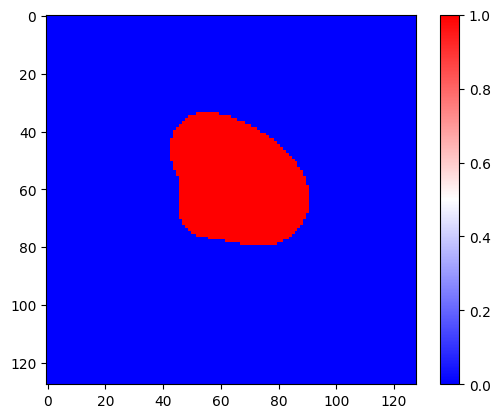

In [143]:
thresholded_gt_mod = display_otsus(extracted_mod_img)
plt.imshow(thresholded_gt_mod, cmap='bwr', interpolation='nearest')
plt.colorbar()

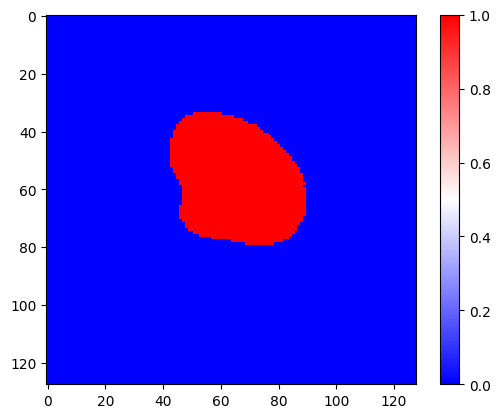

In [194]:
thresholded_pred_mod = display_otsus(prediction[0])
plt.imshow(thresholded_pred_mod, cmap='bwr', interpolation='nearest')
plt.colorbar()

In [200]:
valued = prediction[0].numpy().squeeze()

In [201]:
thresholded_pred_mod.shape

(128, 128)

In [202]:
thresholded_pred_mod

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [203]:
thresholded_pred_mod.sum()

1692

In [207]:
valued[thresholded_pred_mod].shape

(1692,)

In [209]:
pred_mod_inclusion = valued[thresholded_pred_mod]

In [211]:
numpy_data.shape

(128, 128)

In [212]:
gt_mod_inclusion = numpy_data[thresholded_gt_mod]

In [213]:
gt_mod_inclusion.shape

(1707,)

In [218]:
both_thresholded = np.logical_or(thresholded_pred_mod,thresholded_gt_mod)

In [219]:
both_thresholded

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [220]:
op = numpy_data[both_thresholded]

In [222]:
ip = valued[both_thresholded]

In [223]:
op.shape

(2187,)

In [224]:
ip.shape

(2187,)

In [225]:
op

array([1.6238955, 1.6753348, 1.713108 , ..., 1.0000002, 1.0000002,
       1.0000002], dtype=float32)

In [226]:
ip

array([2.0820293, 2.1812413, 2.2249   , ..., 0.9898658, 1.0038503,
       1.027614 ], dtype=float32)

In [228]:
mse = np.mean(np.square(ip-op))
mse

0.49671644

In [231]:
def calculate_mse(predicted_mod_img, thresholded_pred_mod, extracted_mod_img, thresholded_gt_mod):
    both_thresholded = np.logical_or(thresholded_pred_mod,thresholded_gt_mod)
    valued = prediction[0].numpy().squeeze()
    numpy_data = extracted_mod_img[:,:,0].numpy()
    
    ip = valued[both_thresholded]
    op = numpy_data[both_thresholded]
    mse_score = np.mean(np.square(ip-op))

    return mse_score

In [145]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [147]:

dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 
dice_score

0.9838187702265372

In [274]:
dice_matrix = []

In [275]:
mse_loss1_matrix = []
mse_loss2_matrix = []

In [276]:
# extracted = exp_img[200-128:200, 36:164]
# Moving the extraction box of 128*128 downward from the center position(position of transducer)
for j in range(-3,4):
    j_pos = j*10
    list_dice_scores= [] 
    list_mse_loss1 = []
    list_mse_loss2 = []
    k = 0
    for i in range(8):
        pos=i*10
        extracted_disp_img = disp_img[0+pos:128+pos,36+j_pos:164+j_pos]
        extracted_mod_img =  mod_img[0+pos:128+pos,36+j_pos:164+j_pos]

        # plt.figure(figsize=(18, 18), layout='compressed')
        # plt.subplot(8, 3, k+1)
        # plt.imshow(extracted_disp_img, cmap='bwr')
        # plt.colorbar()

        # plt.subplot(8, 3, k+2)
        # plt.imshow(extracted_mod_img, cmap='bwr')
        # plt.colorbar()

        predicted_mod_img = generator(extracted_disp_img[tf.newaxis, ...], training=True)

        # plt.subplot(8, 3, k+3)
        mse_loss1 = tf.keras.losses.MeanSquaredError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
        # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
        
        thresholded_pred_mod = display_otsus(predicted_mod_img[0])
        thresholded_gt_mod = display_otsus(extracted_mod_img)
        dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 
        list_dice_scores.append(dice_score)
        mse_loss2 = calculate_mse(predicted_mod_img[0], thresholded_pred_mod, extracted_mod_img, thresholded_gt_mod)
        
        list_mse_loss1.append(mse_loss1)
        list_mse_loss2.append(mse_loss2)

        # title1 = f'Predicted Dice: {dice_score:.2f} MSE: {mse_loss:.2f}'
        # plt.title(title1)
        # plt.imshow(predicted_mod_img[0], cmap='bwr')
        # plt.colorbar()

        k = k + 3
        # if i == 2:
        #     break
        
    # plt.tight_layout(
    # plt.savefig('traversal.png', bbox_inches='tight')
    # plt.show()
    # plt.close()
    dice_matrix.append(list_dice_scores)
    mse_loss1_matrix.append(list_mse_loss1)
    mse_loss2_matrix.append(list_mse_loss2)

In [277]:
# dice_matrix.append(list_dice_scores)

In [278]:
dice_matrix=np.array(dice_matrix).transpose()

In [279]:
mse_loss1_matrix = np.array(mse_loss1_matrix).transpose()
mse_loss2_matrix = np.array(mse_loss2_matrix).transpose()

In [280]:
dice_matrix.shape

(8, 7)

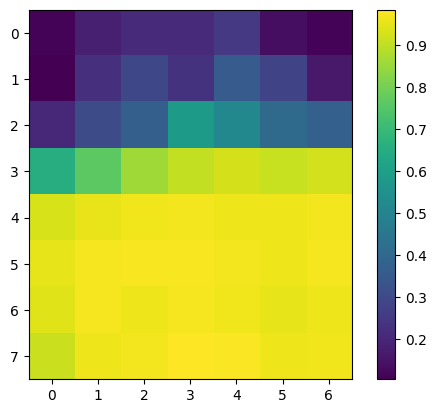

In [281]:
plt.imshow(dice_matrix)
plt.colorbar()

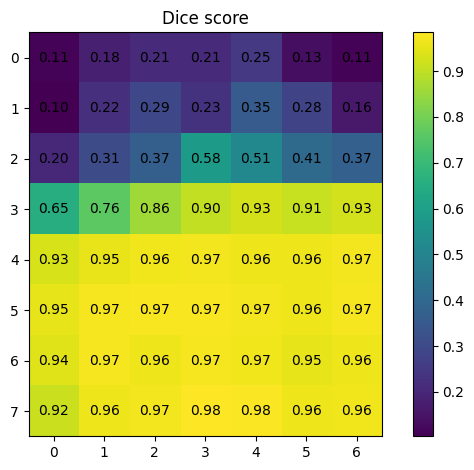

In [284]:
fig, ax = plt.subplots()
im = ax.imshow(dice_matrix)

# Loop over data dimensions and create text annotations.
for i in range(8):
    for j in range(7):
        text = ax.text(j, i, f'{dice_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black")

ax.set_title("Dice score")
fig.tight_layout()
fig.colorbar(im)
plt.show()
# plt.colorbar()


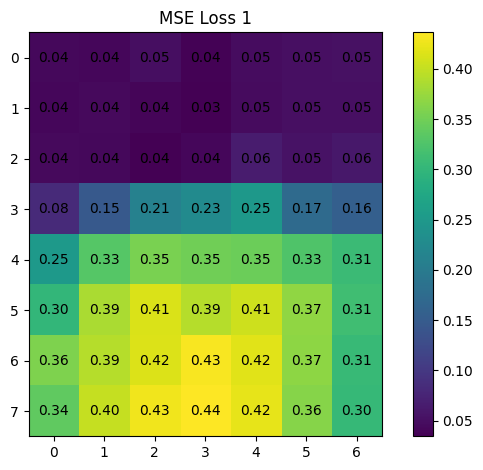

In [286]:
fig, ax = plt.subplots()
im = ax.imshow(mse_loss1_matrix)

# Loop over data dimensions and create text annotations.
for i in range(8):
    for j in range(7):
        text = ax.text(j, i, f'{mse_loss1_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black")

ax.set_title("MSE Loss 1")
fig.tight_layout()
fig.colorbar(im)
plt.show()
# plt.colorbar()

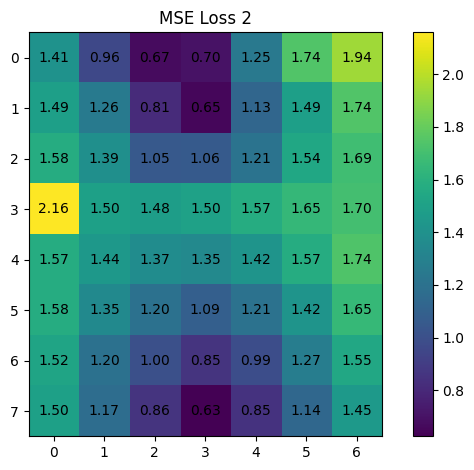

In [287]:
fig, ax = plt.subplots()
im = ax.imshow(mse_loss2_matrix)

# Loop over data dimensions and create text annotations.
for i in range(8):
    for j in range(7):
        text = ax.text(j, i, f'{mse_loss2_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black")

ax.set_title("MSE Loss 2")
fig.tight_layout()
fig.colorbar(im)
plt.show()
# plt.colorbar()

In [247]:
for j in range(-3,4):
    print(j)

-3
-2
-1
0
1
2


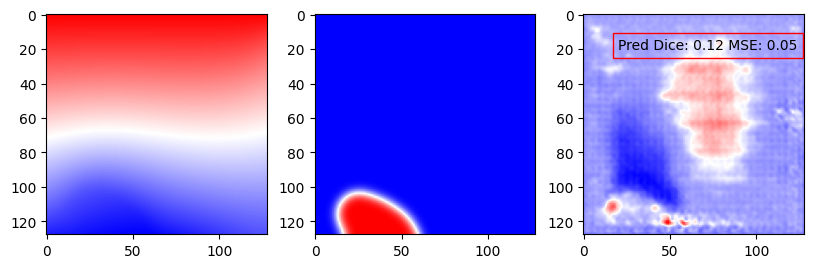

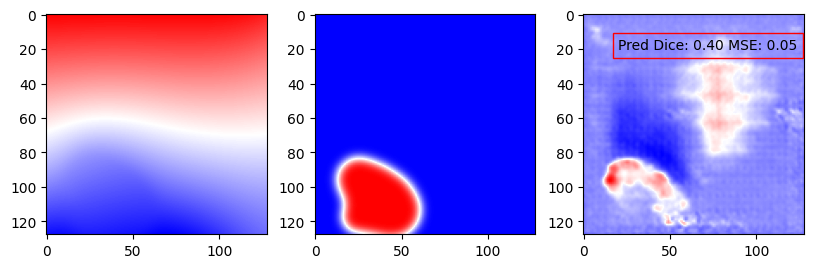

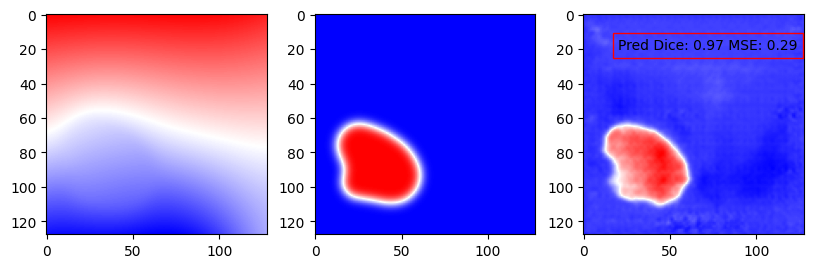

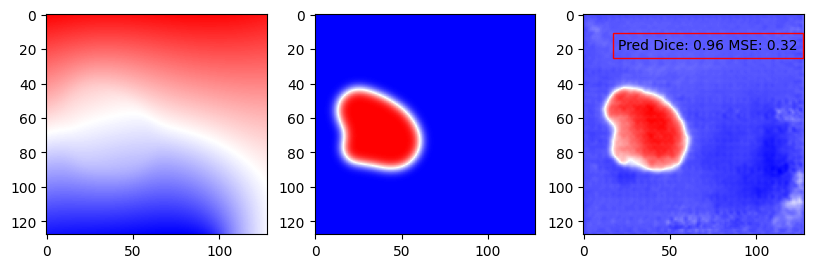

In [242]:
j_pos = 30
k = 0
for i in range(4):
    pos=i*20
    extracted_disp_img = disp_img[0+pos:128+pos,36+j_pos:164+j_pos]
    extracted_mod_img =  mod_img[0+pos:128+pos,36+j_pos:164+j_pos]

    plt.figure(figsize=(18, 18), layout='compressed')
    plt.subplot(8, 3, k+1)
    plt.imshow(extracted_disp_img, cmap='bwr')

    plt.subplot(8, 3, k+2)
    plt.imshow(extracted_mod_img, cmap='bwr')

    predicted_mod_img = generator(extracted_disp_img[tf.newaxis, ...], training=True)

    plt.subplot(8, 3, k+3)
    mse_loss = tf.keras.losses.MeanSquaredError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
    
    thresholded_pred_mod = display_otsus(predicted_mod_img[0])
    thresholded_gt_mod = display_otsus(extracted_mod_img)
    dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 

    title1 = f'Pred Dice: {dice_score:.2f} MSE: {mse_loss:.2f}'
    # plt.title(title1)
    plt.imshow(predicted_mod_img[0], cmap='bwr')
    plt.text(20, 20, title1, bbox=dict(fill=False, edgecolor='red', linewidth=1))

    k = k + 3
    # if i == 2:
    #     break
    
# plt.tight_layout(
plt.savefig('traversal.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()

In [ ]:
# output = np.reshape(prediction, (128,128))
# file_name = f'../../../../TrainData/30\\pred.raw'
# with open(file_name, 'wb') as fp:     
#     output.tofile(fp)
# fp.close()

In [292]:
dataset_base = glob.glob('D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30/*')

In [294]:
dataset_base

['D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\displacement.txt',
 'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\logFile.txt',
 'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\log_modulus_128x128.raw',
 'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\modulus_128x128.raw',
 'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\uX_128x128.raw',
 'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\uY_128x128.raw']

In [295]:
dataset_base[3]

'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\modulus_128x128.raw'

In [296]:
dataset_base[5]

'D://Research/Backups/alldata2/DataInclusions_7_7_2022_PStress/TrainingData/30\\uY_128x128.raw'

In [303]:
base_disp = load2(dataset_base[5],size=(128,128))
base_disp = normalize(base_disp)
base_gt_mod = load2(dataset_base[3],size=(128,128))

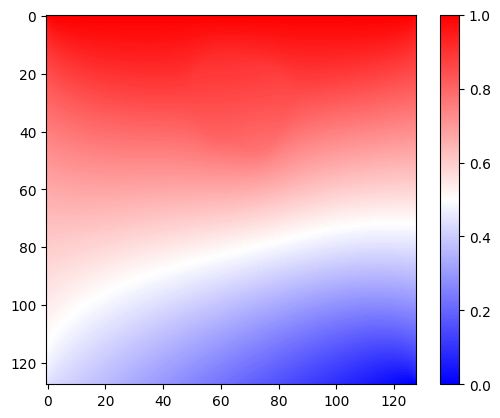

In [304]:
plt.imshow(normalize(base_disp), cmap='bwr')
plt.colorbar()

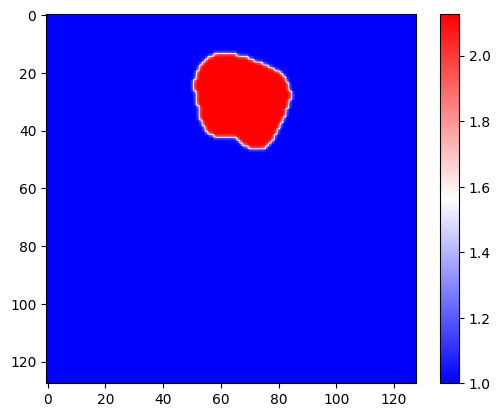

In [305]:
plt.imshow(base_gt_mod, cmap='bwr')
plt.colorbar()

In [306]:
base_pred_mod = generator(base_disp[tf.newaxis, ...], training=True)

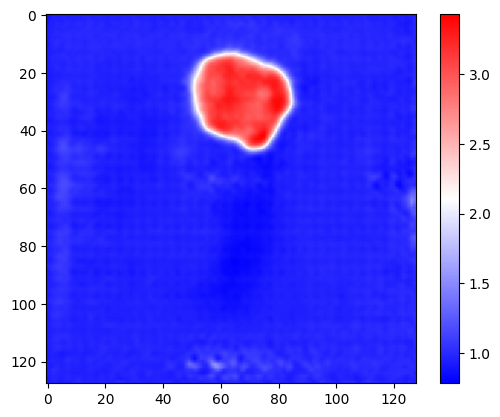

In [307]:
plt.imshow(base_pred_mod[0], cmap='bwr')
plt.colorbar()

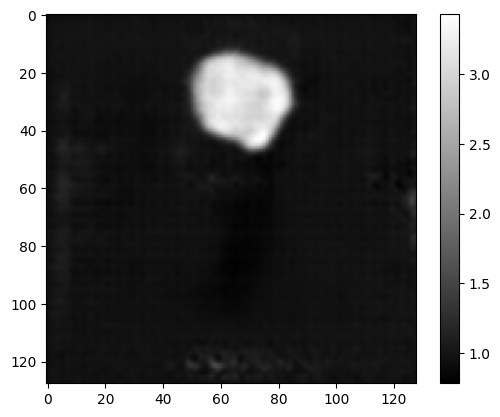

In [308]:
plt.imshow(base_pred_mod[0], cmap='gray')
plt.colorbar()

In [ ]:

# predicted_mod_img = generator(extracted_disp_img[tf.newaxis, ...], training=True)

# plt.subplot(8, 3, k+3)
# mse_loss = tf.keras.losses.MeanSquaredError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()
# # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(extracted_mod_img[0], predicted_mod_img[0]).numpy()

# thresholded_pred_mod = display_otsus(predicted_mod_img[0])
# thresholded_gt_mod = display_otsus(extracted_mod_img)
# dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 

# title1 = f'Pred Dice: {dice_score:.2f} MSE: {mse_loss:.2f}'
# # plt.title(title1)
# plt.imshow(predicted_mod_img[0], cmap='bwr')
# plt.text(20, 20, title1, bbox=dict(fill=False, edgecolor='red', linewidth=1))

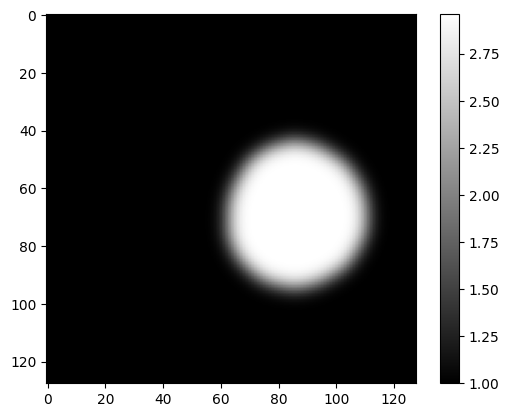

In [354]:
img1 = load2(dataset[0],size=(128,128))
plt.imshow(img1, cmap='gray')
plt.colorbar()

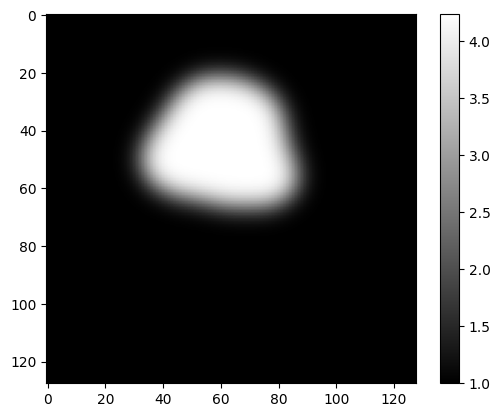

In [357]:
img2 = load2(dataset[1],size=(128,128))
plt.imshow(img2, cmap='gray')
plt.colorbar()

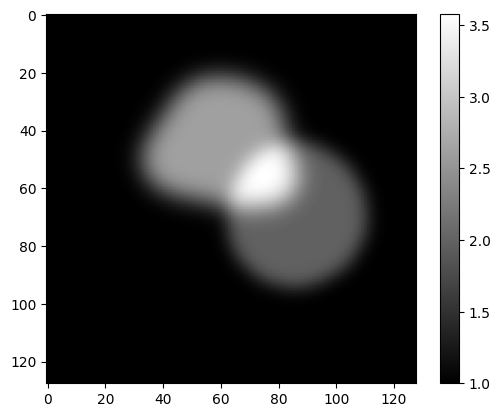

In [356]:
plt.imshow((img1+img2)/2, cmap='gray')
plt.colorbar()

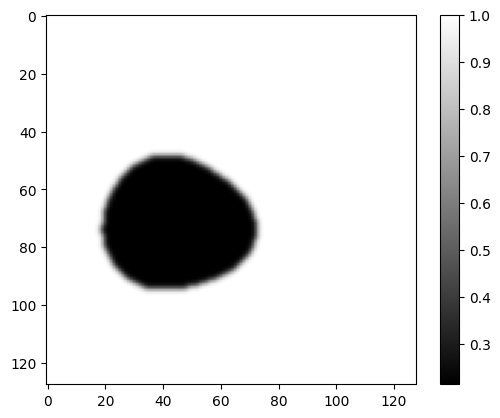

In [358]:
img3 = load2(dataset[2],size=(128,128))
plt.imshow(img3, cmap='gray')
plt.colorbar()

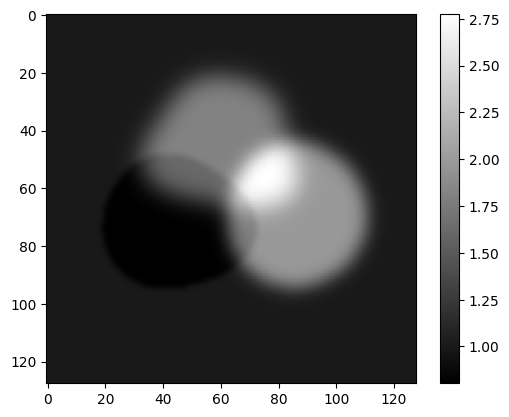

In [360]:
plt.imshow((img1+img2+img3+img1)/4, cmap='gray')
plt.colorbar()

In [368]:
total_img = load2(dataset[0],size=(128,128))
c = 1
for img in dataset:
    img1 = load2(img,size=(128,128))
    total_img = total_img + img1
    c = c + 1 
    if c == 5:
       break
final_img = total_img/(c)

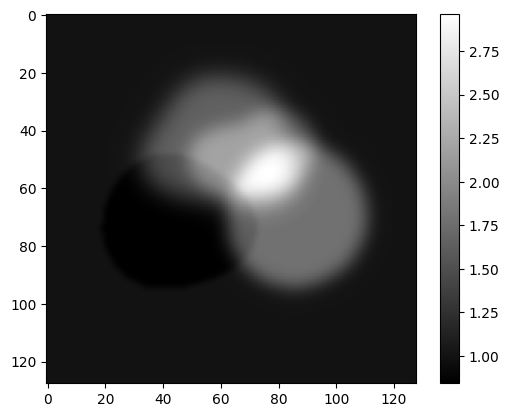

In [369]:
plt.imshow(final_img, cmap='gray')
plt.colorbar()

In [370]:
total_img = load2(dataset[0],size=(128,128))
c = 1
for img in dataset:
    img1 = load2(img,size=(128,128))
    total_img = total_img + img1
    c = c + 1 
    # if c == 5:
    #    break
final_img = total_img/(c)

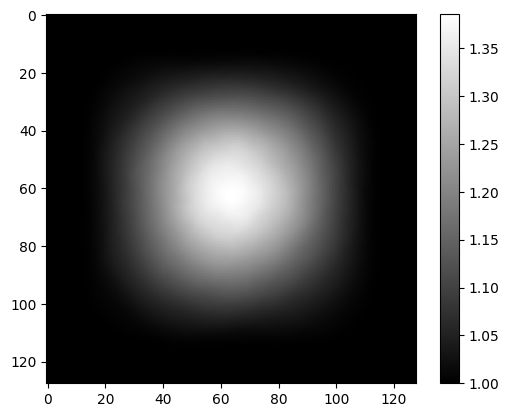

In [371]:
plt.imshow(final_img, cmap='gray')
plt.colorbar()

In [336]:
final_img1

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [346]:
final_img1[10]

array([1.0000001, 1.0000001, 1.0000001, 1.0000001, 1.0000001, 1.0000001,
       1.0000001, 1.0000001, 1.0000001, 1.0000001, 1.0000001, 1.0000001,
       1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002,
       1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002,
       1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002,
       1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002,
       1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002, 1.0000002,
       1.0000015, 1.0000043, 1.0000095, 1.0000191, 1.0000354, 1.0000614,
       1.0001004, 1.0001553, 1.0002283, 1.0003189, 1.0004249, 1.0005413,
       1.0006601, 1.0007738, 1.0008745, 1.0009557, 1.0010123, 1.0010413,
       1.0010413, 1.0010123, 1.0009557, 1.0008745, 1.0007738, 1.0006601,
       1.0005413, 1.0004249, 1.0003189, 1.0002283, 1.0001553, 1.0001004,
       1.0000614, 1.0000354, 1.0000191, 1.0000095, 1.0000043, 1.0000015,
       1.0000002, 1.0000002, 1.0000002, 1.0000002, 

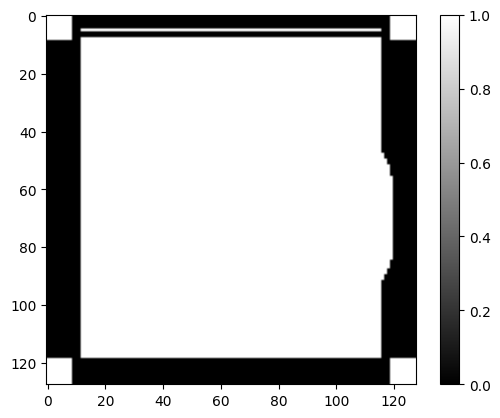

In [339]:
final_img1= final_img[:,:,0].numpy()
soft = (final_img1 != 1.0000001).astype(int)
plt.imshow(soft, cmap='gray')
plt.colorbar()

In [335]:
soft[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [301]:
total_img = load2(dataset[0],size=(128,128))
c = 1 
for img in dataset:
    img1 = load2(img,size=(128,128))
    total_img = total_img + img1
    c = c + 1 
    # if c == 5:
    #    break
final_img = total_img/(c)

In [302]:
c

8984

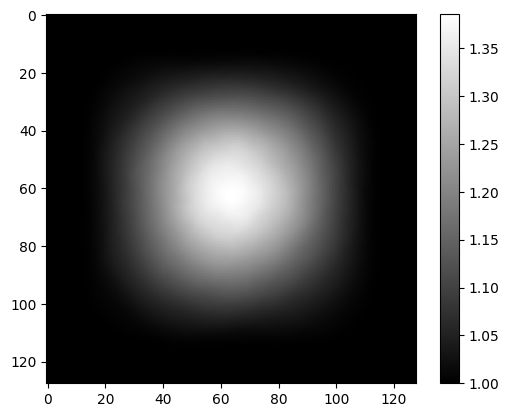

In [303]:
plt.imshow(final_img, cmap='gray')
plt.colorbar()

In [304]:
final_img

<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)>

In [308]:
final_img[:,:,0].shape

TensorShape([128, 128])

In [310]:
final_img1= final_img[:,:,0].numpy()
final_img1.shape

(128, 128)

In [313]:
soft = (final_img1 > 1).astype(int)

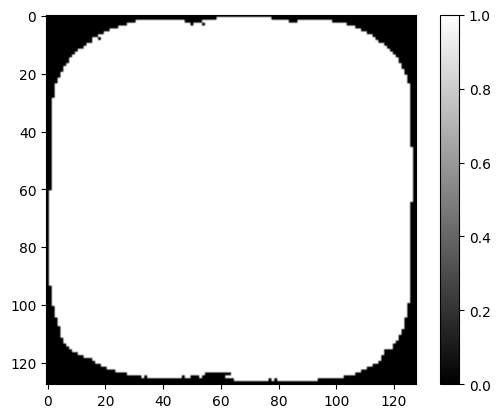

In [314]:
plt.imshow(soft, cmap='gray')
plt.colorbar()

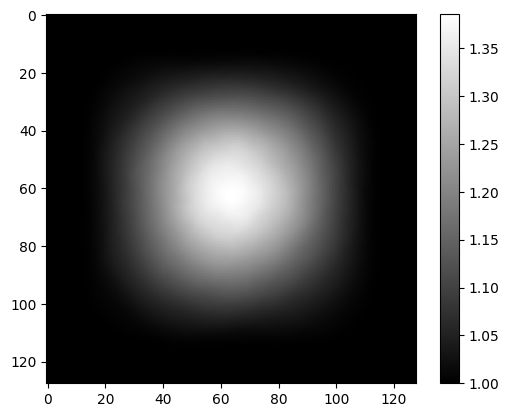

In [280]:
total_img = load2(dataset[0],size=(128,128))
count = 1 
for img in dataset:
    img1 = load2(img,size=(128,128))
    total_img = total_img + img1
    total_img = total_img/2
    count = count + 1 
    # if count == 5:
    #     break

In [281]:
count

8984

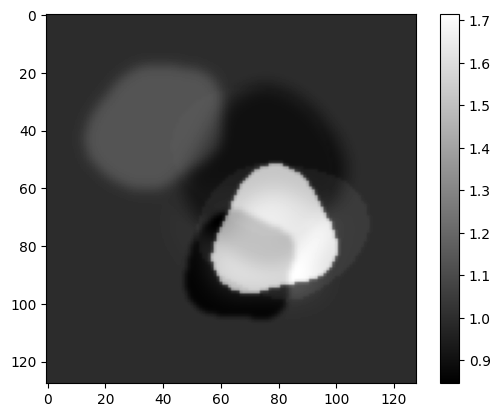

In [282]:
plt.imshow(total_img, cmap='gray')
plt.colorbar()

In [283]:
total_img

<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[1.        ],
        [0.99999994],
        [0.99999994],
        ...,
        [0.99999994],
        [0.99999994],
        [1.        ]],

       [[0.99999994],
        [0.9999999 ],
        [0.9999999 ],
        ...,
        [0.9999999 ],
        [0.9999999 ],
        [0.99999994]],

       [[0.99999994],
        [0.9999999 ],
        [0.9999999 ],
        ...,
        [0.9999999 ],
        [0.9999999 ],
        [0.99999994]],

       ...,

       [[0.99999994],
        [0.9999999 ],
        [0.9999999 ],
        ...,
        [0.9999999 ],
        [0.9999999 ],
        [0.99999994]],

       [[0.99999994],
        [0.9999999 ],
        [0.9999999 ],
        ...,
        [0.9999999 ],
        [0.9999999 ],
        [0.99999994]],

       [[1.        ],
        [0.99999994],
        [0.99999994],
        ...,
        [0.99999994],
        [0.99999994],
        [1.        ]]], dtype=float32)>

In [233]:
img2 = load2(dataset[2],size=(128,128))

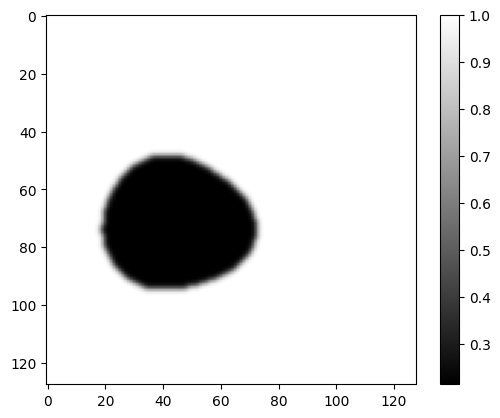

In [234]:
plt.imshow(img2, cmap='gray')
plt.colorbar()

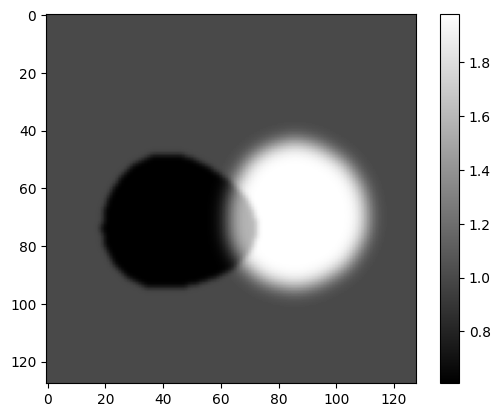

In [240]:
img_3 = (img1+img2)/2
plt.imshow(img_3, cmap='gray')
plt.colorbar()

In [228]:
len(dataset)

8983

In [171]:
exp_img = load2(clinical_images[1])

In [172]:
exp_img.shape

TensorShape([508, 2596, 1])

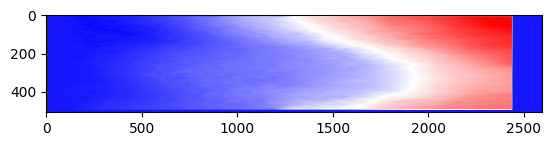

In [173]:
plt.imshow(exp_img, cmap='bwr')

In [174]:
final = remove_zero_pad(exp_img)
final.shape

NameError: name 'remove_zero_pad' is not defined

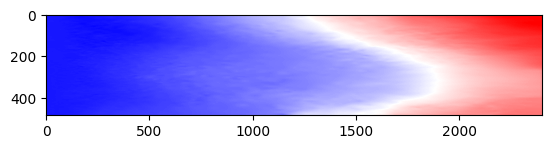

In [ ]:
plt.imshow(final, cmap='bwr')

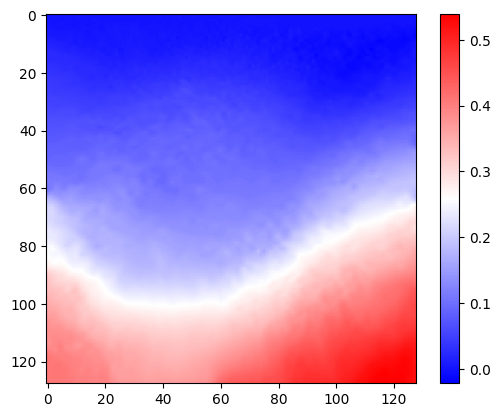

In [ ]:
exp_image_2 = tf.image.resize(final, (128,128))
exp_image_3 = tf.image.rot90(exp_image_2,3)
plt.imshow(exp_image_3, cmap='bwr')
plt.colorbar()

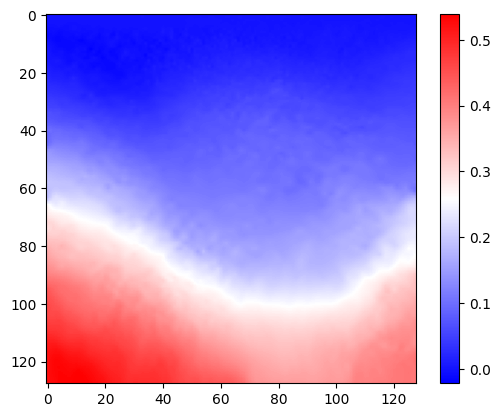

In [ ]:
exp_image_4 = tf.image.flip_left_right(exp_image_3)
plt.imshow(exp_image_4, cmap='bwr')
plt.colorbar()

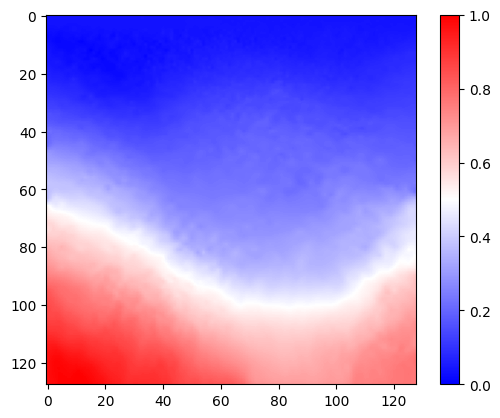

In [ ]:
exp_img_5 = normalize(exp_image_4)
plt.imshow(exp_img_5, cmap='bwr')
plt.colorbar()

In [ ]:
exp_img_5 = normalize(exp_image_4)
plt.imshow(exp_image_5, cmap='bwr')
plt.colorbar()
exp_img_5 = exp_img_5[tf.newaxis, ...]

NameError: name 'exp_image_5' is not defined

In [ ]:
prediction = generator(exp_img_5[tf.newaxis, ...], training=True)

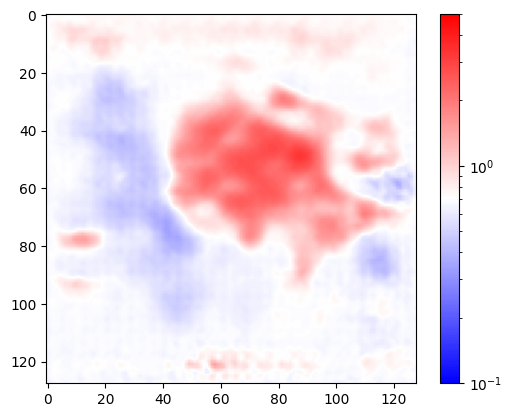

In [ ]:
plt.imshow(prediction[0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
plt.colorbar()

In [ ]:
exp_img_6 = exp_img_6[tf.newaxis, ...]

In [ ]:
prediction = generator(exp_img_6, training=True)

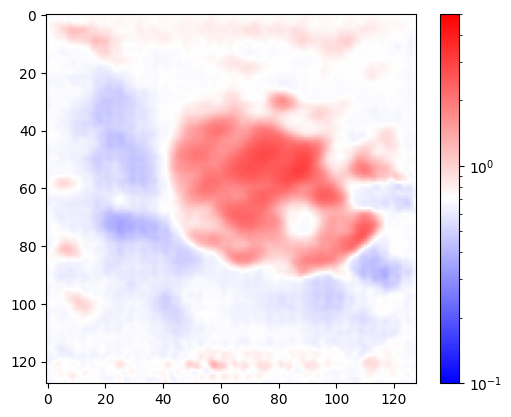

In [ ]:
plt.imshow(prediction[0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
plt.colorbar()

# For Patient 1 - our disp

In [ ]:
def remove_zero_pad(image):
    dummy = np.argwhere(image != 0) # assume blackground is zero
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()
    crop_image = image[min_y:max_y, min_x:max_x]
    return crop_image

In [ ]:
def normalize2(dataY):
    dataY = 1 - dataY
    # max = tf.reduce_max(dataY)
    # min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    # dataY = (dataY - min)/(max - min)
    return dataY

# For Patient 1 - Disp and mods

In [ ]:
clinical_images = glob.glob('patientdata/*')

In [ ]:
clinical_images

['patientdata\\patient1_hasandisp.raw',
 'patientdata\\patient1_ux1.raw',
 'patientdata\\patient2_hasandisp.raw',
 'patientdata\\patient2_ux.raw',
 'patientdata\\patient3_hasandisp.raw',
 'patientdata\\patient3_ux.raw',
 'patientdata\\patient4_hasandisp.raw',
 'patientdata\\patient4_ux.raw']

In [ ]:
hasan_disp = clinical_images[0]
our_disp = clinical_images[1]

In [ ]:
def load_disp(disp_path, owner='hasan'):
    exp_img = load2(disp_path)
    final = remove_zero_pad(exp_img)
    exp_image_2 = tf.image.resize(final, (128,128))
    exp_image_3 = tf.image.rot90(exp_image_2,3)
    exp_image_4 = tf.image.flip_left_right(exp_image_3)
    exp_img_5 = normalize(exp_image_4)
    if owner == 'us':
        exp_img_5 = normalize2(exp_img_5)
    return exp_img_5

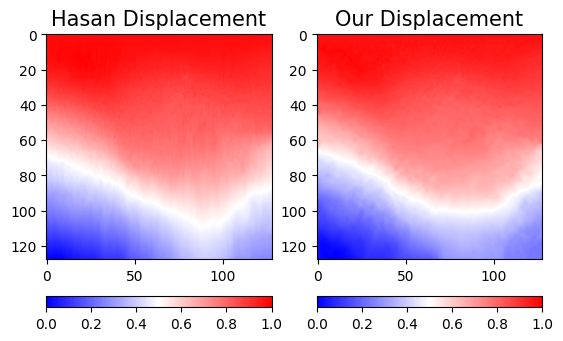

In [ ]:
hasan_disp_image = load_disp(hasan_disp)
our_disp_image = load_disp(our_disp, 'us')
display_list = [hasan_disp_image, our_disp_image]
title = ['Hasan Displacement', 'Our Displacement']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr')
    # plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
hasan_mod_image = generator(hasan_disp_image[tf.newaxis, ...], training=True)
our_mod_image = generator(our_disp_image[tf.newaxis, ...], training=True)

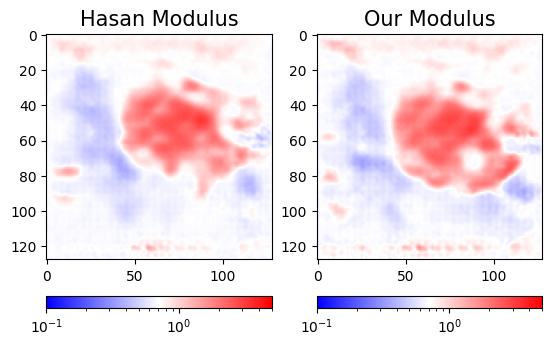

In [ ]:
display_list = [hasan_mod_image[0], our_mod_image[0]]
title = ['Hasan Modulus', 'Our Modulus']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # ticks = np.linspace(0, 5, 0.5, endpoint=True)
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
our_disp_image.shape

TensorShape([128, 128, 1])

In [ ]:
our_disp_image[:,:,0].shape

TensorShape([128, 128])

In [ ]:
strain = np.gradient(tf.squeeze(our_disp_image), axis = 0)
strain.shape

(128, 128)

Text(0.5, 1.0, 'Axial strain')

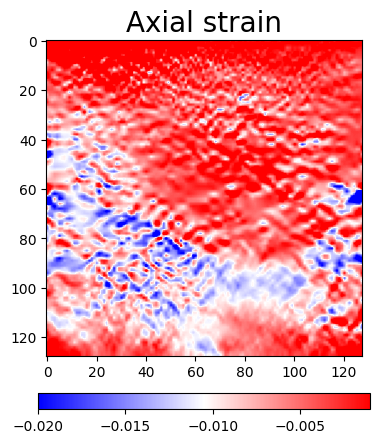

In [ ]:
strain = np.gradient(tf.squeeze(our_disp_image), axis = 0)
# strain2 = normalize(strain)
plt.imshow(strain,cmap='bwr')
plt.clim(-.02,-0.001)
plt.colorbar(location = 'bottom',fraction=0.045, pad=0.10)
plt.title('Axial strain', fontsize=20)

# For Patient 2 - Disp and mods

In [ ]:
clinical_images = glob.glob('patientdata/*')

In [ ]:
clinical_images

['patientdata\\patient1_hasandisp.raw',
 'patientdata\\patient1_ux1.raw',
 'patientdata\\patient2_hasandisp.raw',
 'patientdata\\patient2_ux.raw',
 'patientdata\\patient3_hasandisp.raw',
 'patientdata\\patient3_ux.raw',
 'patientdata\\patient4_hasandisp.raw',
 'patientdata\\patient4_ux.raw']

In [ ]:
hasan_disp = clinical_images[2]
our_disp = clinical_images[3]

In [ ]:
def load_disp(disp_path, owner='hasan'):
    exp_img = load2(disp_path,size=(360,3116))
    final = remove_zero_pad(exp_img)
    exp_image_2 = tf.image.resize(final, (128,128))
    exp_image_3 = tf.image.rot90(exp_image_2,3)
    exp_image_4 = tf.image.flip_left_right(exp_image_3)
    exp_img_5 = normalize(exp_image_4)
    if owner == 'us':
        exp_img_5 = normalize2(exp_img_5)
    return exp_img_5

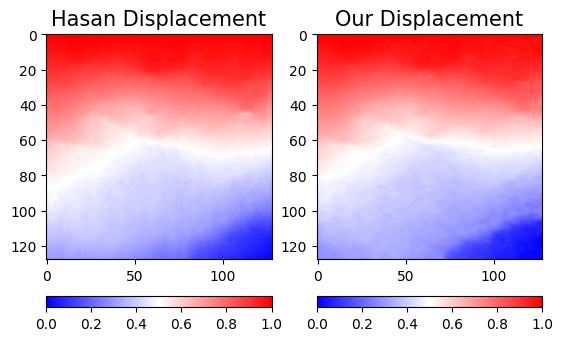

In [ ]:
hasan_disp_image = load_disp(hasan_disp)
our_disp_image = load_disp(our_disp, 'us')
display_list = [hasan_disp_image, our_disp_image]
title = ['Hasan Displacement', 'Our Displacement']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr')
    # plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
hasan_mod_image = generator(hasan_disp_image[tf.newaxis, ...], training=True)
our_mod_image = generator(our_disp_image[tf.newaxis, ...], training=True)

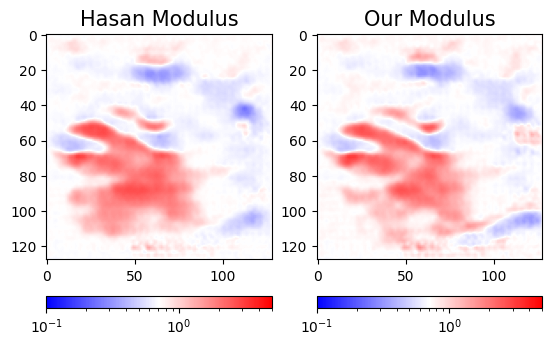

In [ ]:
display_list = [hasan_mod_image[0], our_mod_image[0]]
title = ['Hasan Modulus', 'Our Modulus']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # ticks = np.linspace(0, 5, 0.5, endpoint=True)
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
v

NameError: name 'v' is not defined

# For Patient 3 - Disp and mods

In [ ]:
clinical_images = glob.glob('patientdata/*')

In [ ]:
clinical_images

['patientdata\\patient1_hasandisp.raw',
 'patientdata\\patient1_ux1.raw',
 'patientdata\\patient2_hasandisp.raw',
 'patientdata\\patient2_ux.raw',
 'patientdata\\patient3_hasandisp.raw',
 'patientdata\\patient3_ux.raw',
 'patientdata\\patient4_hasandisp.raw',
 'patientdata\\patient4_ux.raw']

In [ ]:
hasan_disp = clinical_images[4]
our_disp = clinical_images[5]

In [ ]:
def load_disp(disp_path, owner='hasan'):
    exp_img = load2(disp_path,size=(256,2648))
    final = remove_zero_pad(exp_img)
    exp_image_2 = tf.image.resize(final, (128,128))
    exp_image_3 = tf.image.rot90(exp_image_2,3)
    exp_image_4 = tf.image.flip_left_right(exp_image_3)
    exp_img_5 = normalize(exp_image_4)
    if owner == 'us':
        exp_img_5 = normalize2(exp_img_5)
    return exp_img_5

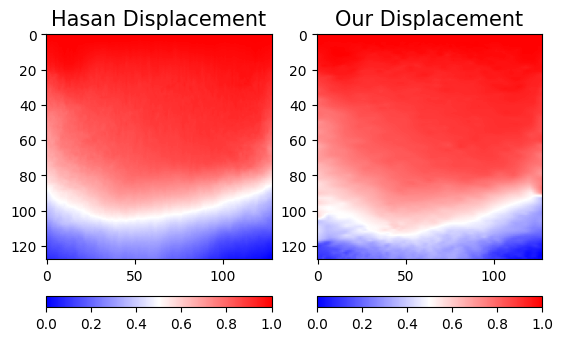

In [ ]:
hasan_disp_image = load_disp(hasan_disp)
our_disp_image = load_disp(our_disp, 'us')
display_list = [hasan_disp_image, our_disp_image]
title = ['Hasan Displacement', 'Our Displacement']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr')
    # plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
hasan_mod_image = generator(hasan_disp_image[tf.newaxis, ...], training=True)
our_mod_image = generator(our_disp_image[tf.newaxis, ...], training=True)

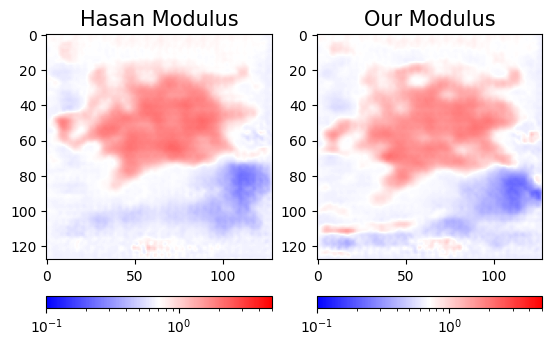

In [ ]:
display_list = [hasan_mod_image[0], our_mod_image[0]]
title = ['Hasan Modulus', 'Our Modulus']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # ticks = np.linspace(0, 5, 0.5, endpoint=True)
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

Text(0.5, 1.0, 'Axial strain')

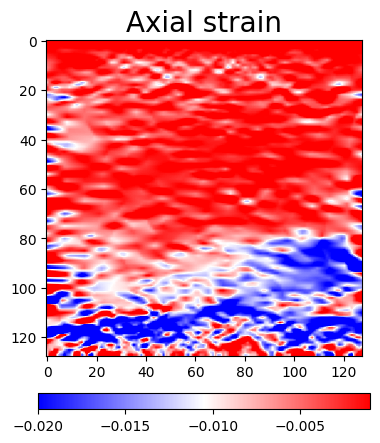

In [ ]:
strain = np.gradient(tf.squeeze(our_disp_image), axis = 0)
# strain2 = normalize(strain)
plt.imshow(strain,cmap='bwr')
plt.clim(-.02,-0.001)
plt.colorbar(location = 'bottom',fraction=0.045, pad=0.10)
plt.title('Axial strain', fontsize=20)

# For Patient 4 - Disp and mods

In [ ]:
clinical_images = glob.glob('patientdata/*')

In [ ]:
clinical_images

['patientdata\\patient1_hasandisp.raw',
 'patientdata\\patient1_ux1.raw',
 'patientdata\\patient2_hasandisp.raw',
 'patientdata\\patient2_ux.raw',
 'patientdata\\patient3_hasandisp.raw',
 'patientdata\\patient3_ux.raw',
 'patientdata\\patient4_hasandisp.raw',
 'patientdata\\patient4_ux.raw']

In [ ]:
hasan_disp = clinical_images[6]
our_disp = clinical_images[7]

In [ ]:
def load_disp(disp_path, owner='hasan'):
    exp_img = load2(disp_path,size=(360,2076))
    final = remove_zero_pad(exp_img)
    exp_image_2 = tf.image.resize(final, (128,128))
    exp_image_3 = tf.image.rot90(exp_image_2,3)
    exp_image_4 = tf.image.flip_left_right(exp_image_3)
    exp_img_5 = normalize(exp_image_4)
    # if owner == 'us':
    #     exp_img_5 = normalize2(exp_img_5)
    return exp_img_5

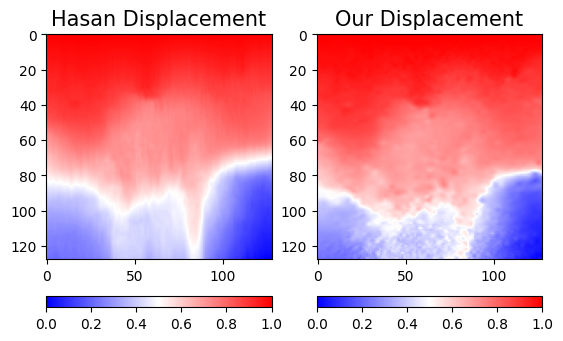

In [ ]:
hasan_disp_image = load_disp(hasan_disp)
our_disp_image = load_disp(our_disp, 'us')
display_list = [hasan_disp_image, our_disp_image]
title = ['Hasan Displacement', 'Our Displacement']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr')
    # plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
hasan_mod_image = generator(hasan_disp_image[tf.newaxis, ...], training=True)
our_mod_image = generator(our_disp_image[tf.newaxis, ...], training=True)

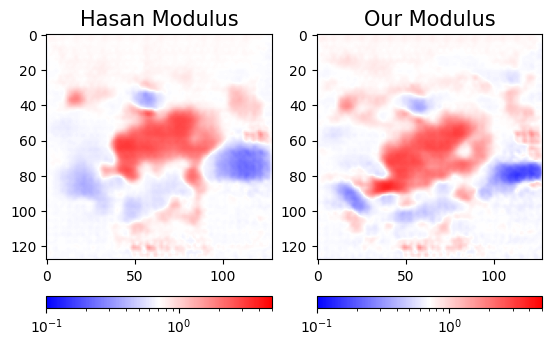

In [ ]:
display_list = [hasan_mod_image[0], our_mod_image[0]]
title = ['Hasan Modulus', 'Our Modulus']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i], fontsize=15)
    plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # ticks = np.linspace(0, 5, 0.5, endpoint=True)
    plt.colorbar(location='bottom',pad=0.10)
    plt.axis('on')

In [ ]:
tf.reduce_max(hasan_mod_image[0])

<tf.Tensor: shape=(), dtype=float32, numpy=3.5261672>

In [ ]:
3.5/0.8

4.375

Text(0.5, 1.0, 'Axial strain')

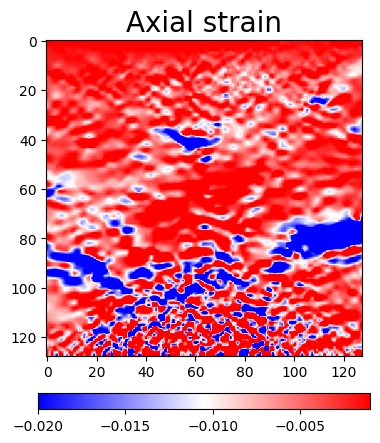

In [ ]:
strain = np.gradient(tf.squeeze(our_disp_image), axis = 0)
# strain2 = normalize(strain)
plt.imshow(strain,cmap='bwr')
plt.clim(-.02,-0.001)
plt.colorbar(location = 'bottom',fraction=0.045, pad=0.10)
plt.title('Axial strain', fontsize=20)